In [1]:
import numpy as np
import pandas as pd
import scipy.signal
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Ideas:
Using simulated E and I to study the spacial newtork changing across the time.
###
spacial network at each timepoint...
  phase calculated by E and I at each ROI... (could be a set of phases due to interpolation using model)
  spacial similarity matrix (spacial network num_ROI*num_ROI) using phase difference among ROIs
cluster those spacial similarity matices across the time....
potential method:
      get a tempo similarity matrix (num_timepoints * num_timepoints) across the time using the spacial similarty matrices
      special clusstering technique: cluster using eigenvectors associated with Laplacian or adjacency matrix
     
      disadvantage: if number of time points is large, svd decomposition is time-consuming 
      

Alternative methods
   at each time point: svd decomposite spacial simarity matrix  to get the leading eigenvectors (num of ROI is smaller... computation efficience)
   those eigenvectors represent a cluster across ROIs (spacial feature at time point)
   idea is to cluster those time points using those eigenvectors associated with the time points, that is, the cluster together those time points with similar spacial features.
   
   
   but: apply different transformation each time -point to do svd decomposition
        sign problem of eigenvectors makes it harder to cluster using thoise eigenvectors
        
        
   Solution:
   get mean of the spacial similarity matrice across time S_plus
   SVD decomposition on S_plus and get U eigenvectors
   For each time point, transform U back to similariy matrix space and get U_t
   Use U_t to cluster (no sign problem and can compare with them)
        
        
####  test on Maca and HCP data: can actually detect the transition states!!!

In [2]:
import numpy as np
from scipy.linalg import fractional_matrix_power


#def eigen(X):
#
#	#machine epsilon used as tolerance
#	eps = np.finfo(float).eps
#
#	U,D = np.eig(X)
#	
#	D = np.diag(D)
	
		
	
		


def gsvd(A, M=[], W=[], exp=0.5):
	
	if M == []:
		M = np.identity(A.shape[0])
	if W == []:
		W = np.identity(A.shape[1])

	#save some typing
	matpow = fractional_matrix_power

	Mexp = matpow(M,exp)
	Wexp = matpow(W,exp)
	
	Ahat = np.matmul(np.matmul(Mexp,A),Wexp)
	
	U,S,Vt = np.linalg.svd(Ahat)
	
	Uhat = np.matmul(matpow(M,-exp),U)
	signb = Uhat[0,0] > 0
	sign = 1
	if not signb:
		sign = -1

	Uhat *= sign
	Vhat = np.matmul(matpow(W,-exp),np.transpose(Vt))
	Vhat *= sign
	return (Uhat,S,Vhat)

In [3]:

out_dir =  '/liberatrix/mcintosh_lab/jwang/ModelFitting/simData_Fr/DecoAdam/'


def get_EI(sub, out_dir, start_tp):
    train_E=np.loadtxt(out_dir+'HCP_'+sub+'sim_fitting_E_test.txt')
    train_I=np.loadtxt(out_dir+'HCP_'+sub+'sim_fitting_I_test.txt')

    test_E=np.loadtxt(out_dir+'HCP_'+sub+'sim_E_test.txt')
    test_I=np.loadtxt(out_dir+'HCP_'+sub+'sim_I_test.txt')
    return train_E[start_tp:], train_I[start_tp:], test_E[start_tp:], test_I[start_tp:]

In [4]:
def plot_manifold_EI(sub, train_E, train_I, test_E, test_I, x_l, x_h, y_l, y_h):
    fig, ax=plt.subplots(1,2)
    ax[0].scatter(train_E.mean(1)[10:], train_I.mean(1)[10:], alpha=0.02)
    ax[0].set_xlim([x_l, x_h])
    ax[0].set_ylim([y_l, y_h])
    ax[1].scatter(test_E.mean(1)[50:], test_I.mean(1)[50:], alpha=0.01)
    ax[1].set_xlim([x_l, x_h])
    ax[1].set_ylim([y_l, y_h])
    plt.suptitle("Manifold of E and I: sub_"+ sub)
    plt.show()
    

##### steps
step 1 get analytical signal
     E + Ij or get hilbert from empirical BOLD
step 2 at each ROI and each time-point
     get angle (phase) -pi to pi
step 3 at each time-point
     get cos similairty matrix
step 4 at each time-point
     svd to get 1st or 2nd eigenvector
step 5 put all the eigenvectors into a bad and cluster them using k-mean




In [37]:



def get_leads_ts(analytic_signal, n_ev):
    phase=np.angle(analytic_signal)
    #phase=np.unwrap(np.angle(analytic_signal))
    Leads = []
    for i in range(phase.shape[0]):
        FC_inst=np.cos(phase[i:i+1,:].T-phase[i:i+1,:])
        FC_inst=FC_inst.T
        
        Leads.append(FC_inst.ravel())#/np.sqrt((FC_inst.ravel()**2).sum()))
    Y=np.array(Leads)
    C = np.corrcoef(Y)#Y.dot(Y.T)
    U, D, V = gsvd(C)#np.linalg.svd(C)
    weight = U[:,0]/U[:,0].sum()
    S_plus = np.zeros_like(FC_inst)
    for i in range(len(weight)):
        S_plus += weight[i]*np.reshape(Leads[i], S_plus.shape)
    U, D, V = gsvd(S_plus)#np.linalg.svd(S_plus)
    Ft = U.dot(np.diag(1./np.sqrt(D)))
    F = U.dot(np.diag(np.sqrt(D)))

    S_transformed = []
    
    if n_ev==12:
        for i in range(len(weight)):
            S_transformed.append(np.reshape(Leads[i], S_plus.shape).dot(Ft[:,:2]).ravel(order='F'))
    else:
        for i in range(len(weight)):
            S_transformed.append(np.reshape(Leads[i], S_plus.shape).dot(Ft)[:,n_ev-1])
        
    return S_transformed

def get_leads_ts(analytic_signal, n_ev):
    phase=np.angle(analytic_signal)
    #phase=np.unwrap(np.angle(analytic_signal))
    Leads = []
    for i in range(phase.shape[0]):
        FC_inst=np.cos(phase[i:i+1,:].T-phase[i:i+1,:])
        FC_inst=FC_inst.T
        
        Leads.append(FC_inst.ravel())#/np.sqrt((FC_inst.ravel()**2).sum()))
    Y=np.array(Leads)
    """C = np.corrcoef(Y)#Y.dot(Y.T)
    U, D, V = gsvd(C)#np.linalg.svd(C)
    weight = U[:,0]/U[:,0].sum()"""
    S_plus = np.reshape(Y.mean(0), (phase.shape[1],phase.shape[1]))

    U, D, V = gsvd(S_plus)#np.linalg.svd(S_plus)
    Ft = U.dot(np.diag(1./np.sqrt(D)))
    F = U.dot(np.diag(np.sqrt(D)))

    S_transformed = []
    
    if n_ev==12:
        for i in range(phase.shape[0]):
            S_transformed.append(np.reshape(Leads[i], S_plus.shape).dot(Ft[:,:2]).ravel(order='F'))
    else:
        for i in range(phase.shape[0]):
            S_transformed.append(np.reshape(Leads[i], S_plus.shape).dot(Ft)[:,n_ev-1])
        
    return S_transformed

In [54]:
def plot_centers(centers, labels, labels_ls, Noev, y_L,y_H, thresh):
    num_subplots=centers.shape[0]
    if num_subplots %3 ==0:
        num_rows = num_subplots//3
    else:
        num_rows = num_subplots//3 +1
    fig, ax = plt.subplots(num_rows, 3, figsize=(12,8))
    for i in range(num_subplots):
        if num_rows> 1:
            ax[i//3, i%3].plot(centers[i,:])
            ax[i//3, i%3].set_ylim([y_L, y_H])
            ax[i//3, i%3].set_title(str(100*np.sum(labels==i)/len(labels)) + "%")
            """if Noev == 1:
                ax[i//3, i%3].annotate(labels_ls[centers[i,:].argmax()], (centers[i,:].argmax(), centers[i,:].max()))
            elif Noev == 2:
                rois=np.arange(len(labels_ls))[np.abs(centers[i,:]) >=thresh]
                print(rois+1)
                if len(rois)>0:
                    for roi in range(len(rois)):
                        ax[i//3, i%3].annotate(labels_ls[rois[roi]], (rois[roi], centers[i,rois[roi]]))
            else:
                ax[i//3, i%3].annotate(labels_ls[centers[i,:len(labels_ls)].argmax()], (centers[i,:len(labels_ls)].argmax(), centers[i,:len(labels_ls)].max()))
                rois=np.arange(len(labels_ls))[np.abs(centers[i,len(labels_ls):]) >=thresh]
                if len(rois)>0:
                    for roi in range(len(rois)):
                        ax[i//3, i%3].annotate(labels_ls[rois[roi]], (len(labels_ls)+rois[roi], centers[i,len(labels_ls)+rois[roi]]))
                """
        else:
            ax[i%3].plot(centers[i,:])
            ax[i%3].set_ylim([y_L, y_H])
            ax[i%3].set_title(str(100*np.sum(labels==i)/len(labels)) + "%")
            """if Noev == 1:
                ax[i%3].annotate(labels_ls[centers[i,:].argmax()], (centers[i,:].argmax(), centers[i,:].max()))
            elif Noev == 2:
                rois=np.arange(labels_ls)[np.abs(centers[i,:]) >=thresh]
                print(rois+1)
                if len(rois)>0:
                    for roi in range(len(rois)):
                        ax[i%3].annotate(labels_ls[rois[roi]], (rois[roi], centers[i,rois[roi]]))
            else:
                ax[i//3, i%3].annotate(labels_ls[centers[i,:labels_ls].argmax()], (centers[i,:labels_ls].argmax(), centers[i,:labels_ls].max()))
                rois=np.arange(labels_ls)[np.abs(centers[i,labels_ls:]) >=thresh]
                if len(rois)>0:
                    for roi in range(len(rois)):
                        ax[i%3].annotate(labels_ls[rois[roi]], (labels_ls+rois[roi], centers[i,labels_ls+rois[roi]]))"""
        

In [7]:
f=open('resolution83_LUT.txt', 'r')
labels={}
for line in f:
    if line[0].isdigit():
        label_tmp=[c for c in line[:-2].split(' ') if len(c) > 0]
        labels[int(label_tmp[0])-1] = label_tmp[1]
f.close()
#labels

In [8]:
labels_ls =[]
for i in range(83):
    labels_ls.append(labels[i])
#labels_ls

In [7]:

def leads_train(X, n_clusters):
    
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    return labels, centers

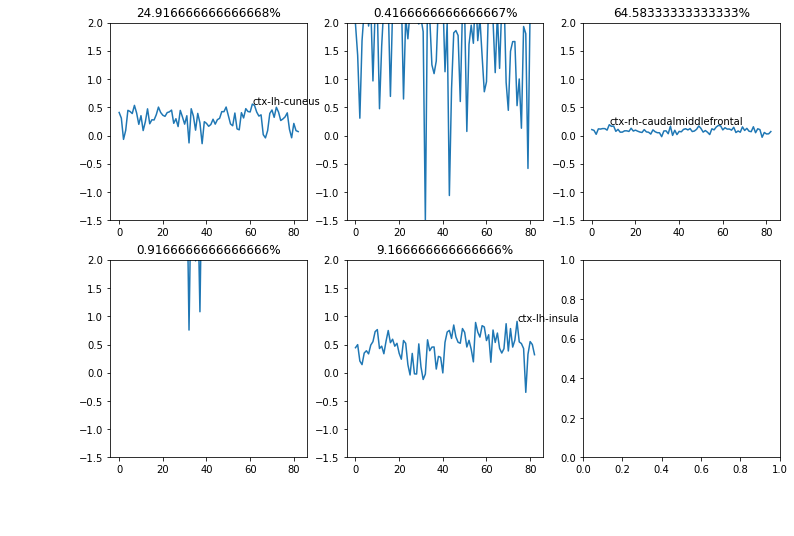

In [408]:
sub='154532'
out_dir =  '/liberatrix/mcintosh_lab/jwang/ModelFitting/simData_Fr/DecoAdam/'
ts_base_dir='/gerda/mcintosh_lab/jgriffiths/hcp_wuminn_l2k8_rsfmri_ts/data/results/'
ts_file = ts_base_dir+sub+'_rfMRI_REST1_LR_hpc200_clean__l2k8_sc33_ts.pkl'
ts_df = pd.read_pickle(ts_file)
ts = ts_df.values


train_E, train_I, test_E, test_I = get_EI(sub, out_dir, 0)
analytic_signal_trained = train_E-train_E.mean(0) +(train_I -train_I.mean(0))*1j#scipy.signal.hilbert(ts,axis=0)
Leads_trained_2nd = get_leads_ts(analytic_signal_trained, 1)

X_trained_2nd = np.array(Leads_trained_2nd)
labels_trained_2nd, centers_trained_2nd = leads_train(X_trained_2nd, 5)

plot_centers(centers_trained_2nd, labels_trained_2nd, labels_ls, 1, -1.5, 2., 0.1)


In [387]:
sub='154532'
out_dir =  '/liberatrix/mcintosh_lab/jwang/ModelFitting/simData_Fr/DecoAdam/'
ts_base_dir='/gerda/mcintosh_lab/jgriffiths/hcp_wuminn_l2k8_rsfmri_ts/data/results/'
ts_file = ts_base_dir+sub+'_rfMRI_REST1_LR_hpc200_clean__l2k8_sc33_ts.pkl'
ts_df = pd.read_pickle(ts_file)
ts = ts_df.values


train_E, train_I, test_E, test_I = get_EI(sub, out_dir, 0)
analytic_signal_trained = train_E-train_E.mean(0) +(train_I -train_I.mean(0))*1j#scipy.signal.hilbert(ts,axis=0)
Leads_trained_2nd = get_leads_ts(analytic_signal_trained, 1)

In [388]:
X_trained_2nd = np.array(Leads_trained_2nd)
labels_trained_2nd, centers_trained_2nd = leads_train(X_trained_2nd, 5)

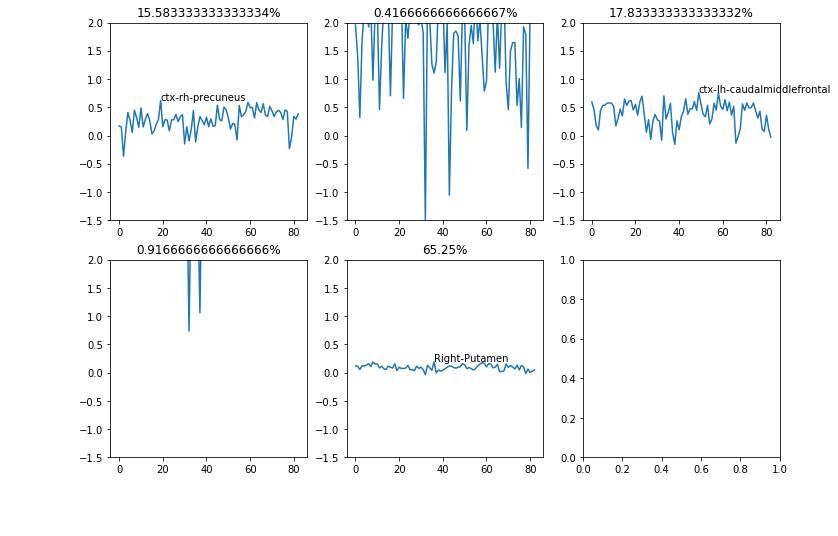

In [389]:
#labels_ls=np.arange(60)
plot_centers(centers_trained_2nd, labels_trained_2nd, labels_ls, 1, -1.5, 2., 0.1)

In [390]:
train_E, train_I, test_E, test_I = get_EI(sub, out_dir, 200)
analytic_signal_trained = train_E-train_E.mean(0) +(train_I -train_I.mean(0))*1j#scipy.signal.hilbert(ts,axis=0)
Leads_trained_2nd = get_leads_ts(analytic_signal_trained, 1)

In [391]:
X_trained_2nd = np.array(Leads_trained_2nd)
labels_trained_2nd, centers_trained_2nd = leads_train(X_trained_2nd, 5)

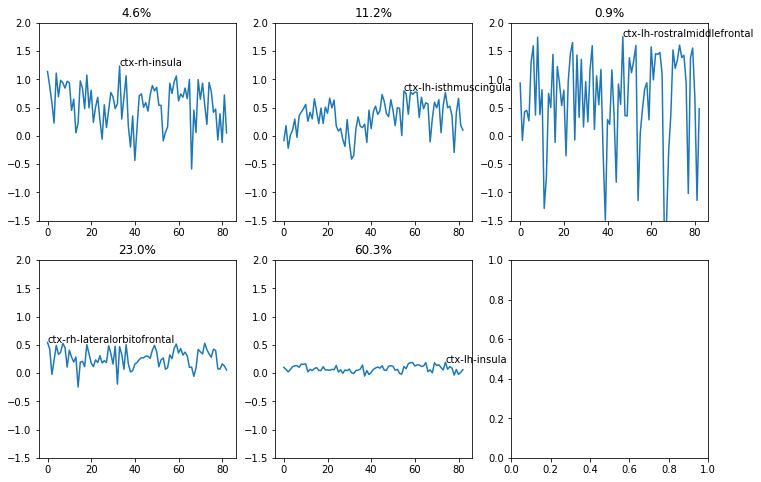

In [392]:
#labels_ls=np.arange(60)
plot_centers(centers_trained_2nd, labels_trained_2nd, labels_ls, 1, -1.5, 2., 0.1)

In [393]:
#### comparison between subjects
sub='154532'
out_dir =  '/liberatrix/mcintosh_lab/jwang/ModelFitting/simData_Fr/DecoAdam/'

train_E_1, train_I_1, test_E_1, test_I_1 = get_EI(sub, out_dir, 200)

sub='180432'
train_E_2, train_I_2, test_E_2, test_I_2 = get_EI(sub, out_dir, 200)

test_E= np.vstack((test_E_1- test_E_1.mean(0), test_E_2 -test_E_2.mean(0)))
test_I= np.vstack((test_I_1 -test_I_1.mean(0), test_I_2 -test_I_2.mean(0)))


"""sub='180432'
train_E, train_I, test_E, test_I = get_EI(sub, out_dir)"""

analytic_signal_test = test_E +(test_I)*1j#scipy.signal.hilbert(ts,axis=0)
Leads_test = get_leads_ts(analytic_signal_test, 1)

X_test = np.array(Leads_test)
labels_test, centers_test = leads_train(X_test, 5)


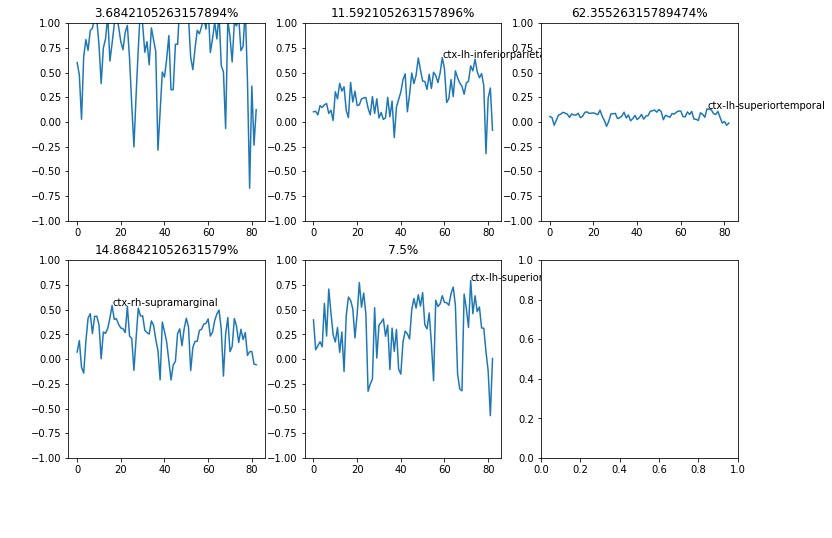

In [394]:
plot_centers(centers_test, labels_test, labels_ls, 1, -1.0, 1.0, 0.1)

In [397]:
#### comparison between subjects
sub='154532'
out_dir =  '/liberatrix/mcintosh_lab/jwang/ModelFitting/simData_Fr/DecoAdam/'

train_E_1, train_I_1, test_E_1, test_I_1 = get_EI(sub, out_dir, 0)

sub='180432'
train_E_2, train_I_2, test_E_2, test_I_2 = get_EI(sub, out_dir, 0)

test_E= np.vstack((test_E_1- test_E_1.mean(0), test_E_2 -test_E_2.mean(0)))
test_I= np.vstack((test_I_1 -test_I_1.mean(0), test_I_2 -test_I_2.mean(0)))


"""sub='180432'
train_E, train_I, test_E, test_I = get_EI(sub, out_dir)"""

analytic_signal_test = test_E +(test_I)*1j#scipy.signal.hilbert(ts,axis=0)
Leads_test = get_leads_ts(analytic_signal_test, 1)

X_test = np.array(Leads_test)
labels_test, centers_test = leads_train(X_test, 5)


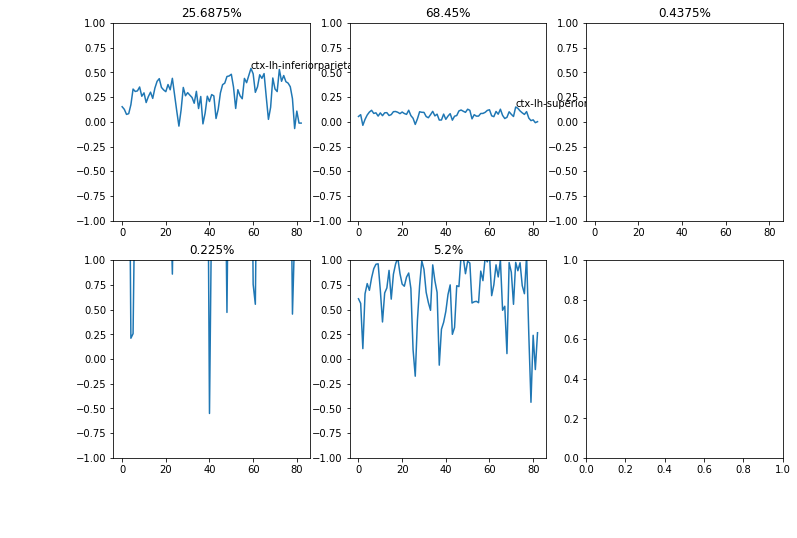

In [398]:
plot_centers(centers_test, labels_test, labels_ls, 1, -1.0, 1.0, 0.1)

In [8]:
####maca datat
##### maca data
out_dir =  '/liberatrix/mcintosh_lab/jwang/ModelFitting/Maca/'
 
def get_EI(sub, out_dir, start_tp):
    train_E=np.loadtxt(out_dir+'Maca_'+sub+'sim_fitting_E_test.txt')
    train_I=np.loadtxt(out_dir+'Maca_'+sub+'sim_fitting_I_test.txt')

    test_E=np.loadtxt(out_dir+'Maca_'+sub+'sim_E_test.txt')
    test_I=np.loadtxt(out_dir+'Maca_'+sub+'sim_I_test.txt')
    return train_E[start_tp:], train_I[start_tp:], test_E[start_tp:], test_I[start_tp:]

In [9]:
f=open('/brunhild/mcintosh_lab/jwang/ModelFitting/Maca/ROIs_82', 'r')
labels_ls=[]
for line in f:
    labels_ls.append(line[:-1])
    
f.close()

In [10]:
labels_ls

['TCpol_R',
 'TCs_R',
 'Amyg_R',
 'PFCoi_R',
 'Ia_R',
 'PFCom_R',
 'TCc_R',
 'PFCol_R',
 'TCi_R',
 'PHC_R',
 'G_R',
 'PMCvl_R',
 'VACv_R',
 'Ip_R',
 'PFCpol_R',
 'HC_R',
 'CCs_R',
 'PFCvl_R',
 'V2_R',
 'PFCm_R',
 'TCv_R',
 'VACd_R',
 'V1_R',
 'PFCcl_R',
 'A2_R',
 'CCr_R',
 'CCp_R',
 'CCa_R',
 'S2_R',
 'S1_R',
 'A1_R',
 'M1_R',
 'PCi_R',
 'PCm_R',
 'PFCdm_R',
 'PCip_R',
 'PCs_R',
 'FEF_R',
 'PFCdl_R',
 'PMCm_R',
 'PMCdl_R',
 'TCpol_L',
 'TCs_L',
 'Amyg_L',
 'PFCoi_L',
 'Ia_L',
 'PFCom_L',
 'TCc_L',
 'PFCol_L',
 'TCi_L',
 'PHC_L',
 'G_L',
 'PMCvl_L',
 'VACv_L',
 'Ip_L',
 'PFCpol_L',
 'HC_L',
 'CCs_L',
 'PFCvl_L',
 'V2_L',
 'PFCm_L',
 'TCv_L',
 'VACd_L',
 'V1_L',
 'PFCcl_L',
 'A2_L',
 'CCr_L',
 'CCp_L',
 'CCa_L',
 'S2_L',
 'S1_L',
 'A1_L',
 'M1_L',
 'PCi_L',
 'PCm_L',
 'PFCdm_L',
 'PCip_L',
 'PCs_L',
 'FEF_L',
 'PFCdl_L',
 'PMCm_L',
 'PMCdl_L']

In [11]:
train_E=[]
train_I=[]
for i in range(1,9):
    for j in range(4):
        
        sub ='Maca_'+str(i)+'_'+str(j)
        print(sub)
    
        train_E_sub, train_I_sub, test_E_sub, test_I_sub = get_EI(sub, out_dir, 0)
        train_E.append(train_E_sub -train_E_sub.mean(0))
        train_I.append(train_I_sub -train_I_sub.mean(0))
train_E = np.concatenate(train_E, axis=0)
train_I = np.concatenate(train_I, axis=0)

Maca_1_0
Maca_1_1
Maca_1_2
Maca_1_3
Maca_2_0
Maca_2_1
Maca_2_2
Maca_2_3
Maca_3_0
Maca_3_1
Maca_3_2
Maca_3_3
Maca_4_0
Maca_4_1
Maca_4_2
Maca_4_3
Maca_5_0
Maca_5_1
Maca_5_2
Maca_5_3
Maca_6_0
Maca_6_1
Maca_6_2
Maca_6_3
Maca_7_0
Maca_7_1
Maca_7_2
Maca_7_3
Maca_8_0
Maca_8_1
Maca_8_2
Maca_8_3


In [15]:
#### experical data
file_name = '/liberatrix/mcintosh_lab/kshen/TVBmacaque/forZhengmacaque_SC_timeseries.mat'

import scipy.io
data = scipy.io.loadmat(file_name)
analytic_signal_exp=[]
for i in range(1):
    for j in range(2):
        ts = data['rsfMRI_timeseries'][i,j,:,:]
        analytic_signal_exp.append(scipy.signal.hilbert(ts,axis=0))
analytic_signal_exp = np.vstack((analytic_signal_exp))
analytic_signal_exp.shape

(1200, 82)

In [59]:
analytic_signal_exp[:5]

array([[  9.98702447-1.62829244e+01j,  61.10299601-3.56450942e+01j,
          1.80622926-2.30014934e+00j,  15.7831696 -2.37020423e+01j,
          6.93912918-1.52651022e+00j,  17.52626329+3.77694586e+00j,
         28.4756052 -1.48862514e+01j,  13.19150161-8.24950797e-01j,
          8.40549349-1.58326951e+00j,  14.92194981-4.48377586e+00j,
         24.61662974-2.38937858e+01j,  49.38816959-8.48621435e+00j,
         12.1227936 -1.88366120e+01j,  24.21552044-3.78108786e+01j,
         27.65569578-2.70126162e+01j,   2.19907865+1.62642490e+01j,
          1.31278301+2.85450126e+01j,  34.21186567-1.18017408e+01j,
          1.07046009-2.45567334e-01j,  11.2132758 -2.20392343e+01j,
         23.50015405-2.84119882e+01j,  44.58794565-2.82976077e+01j,
          5.93788035-7.71352562e-01j,  35.21955178-2.75888223e+01j,
        100.01631067-7.10886245e+01j,  22.5231886 -8.41418118e+00j,
         76.47450429-4.65796250e+01j,  54.90037364-4.16563720e+01j,
         94.01726593-8.23426548e+01j,  57.965873

In [38]:

Leads_exp = get_leads_ts(analytic_signal_exp, 1)

X_exp = np.array(Leads_exp)
labels_exp, centers_exp = leads_train(X_exp, 5)

In [41]:
np.savetxt(out_dir+'centers_Maca_exp.txt', centers_exp)
np.savetxt(out_dir+'labels_Maca_exp.txt', labels_exp)

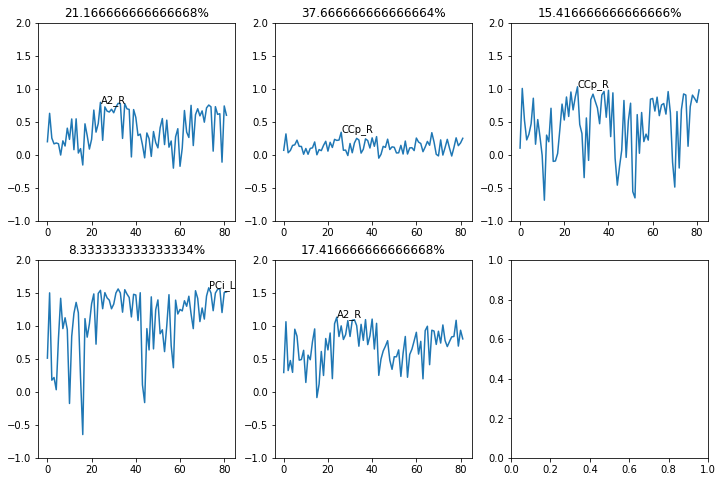

In [39]:
plot_centers(centers_exp, labels_exp, labels_ls, 1, -1.0, 2.0, 0.1)

In [27]:
analytic_signal_train = train_E +(train_I)*1j#scipy.signal.hilbert(ts,axis=0)
Leads_train = get_leads_ts(analytic_signal_train, 1)

X_train = np.array(Leads_train)
labels_train, centers_train = leads_train(X_train, 5)


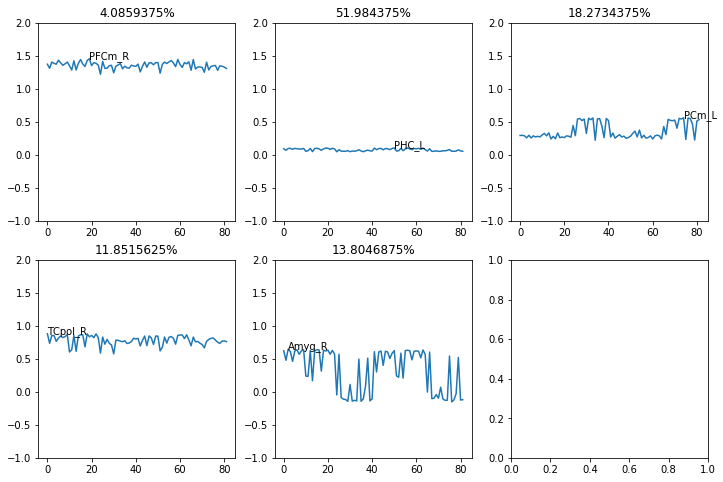

In [24]:
plot_centers(centers_train, labels_train, labels_ls, 1, -1.0, 2.0, 0.1)

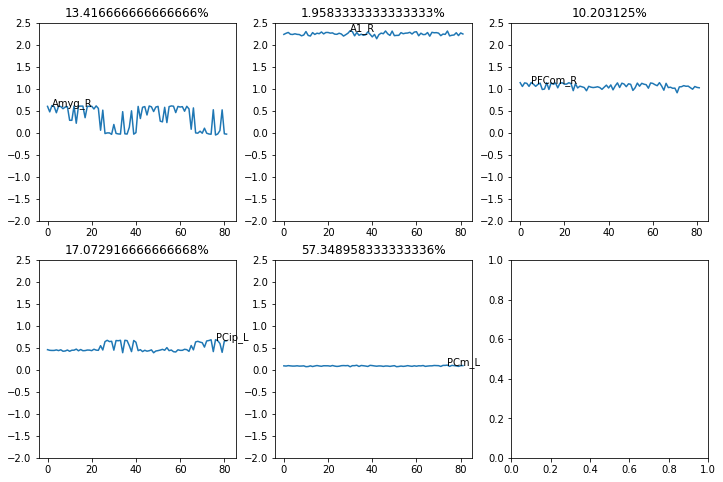

In [28]:
plot_centers(centers_train, labels_train, labels_ls, 1, -2, 2.5, 0.1)

In [76]:

def get_leads_ts(analytic_signal, n_ev):
    phase=np.angle(analytic_signal)
    #phase=np.unwrap(np.angle(analytic_signal))
    Leads = []
    for i in range(phase.shape[0]//50):
        FC_inst=np.corrcoef(phase[i*50:(i+1)*50,:].T)
        #FC_inst=FC_inst.T
        
        Leads.append(FC_inst)#/np.sqrt((FC_inst.ravel()**2).sum()))
    #Y=np.array(Leads)
    """C = np.corrcoef(Y)#Y.dot(Y.T)
    U, D, V = gsvd(C)#np.linalg.svd(C)
    weight = U[:,0]/U[:,0].sum()"""
    S_plus = sum(Leads)/len(Leads)

    U, D, V = gsvd(S_plus)#np.linalg.svd(S_plus)
    Ft = U.dot(np.diag(1./np.sqrt(D)))
    F = U.dot(np.diag(np.sqrt(D)))
    print(D)
    S_transformed = []
    
   
    for i in range(phase.shape[0]//50):
        S_transformed.append(np.reshape(Leads[i], S_plus.shape).dot(Ft[:,:n_ev]).ravel(order='F'))
   
    return S_transformed

In [61]:
train_E=[]
train_I=[]
for i in range(1):
    for j in range(2):
        
        sub ='Maca_'+str(i)+'_'+str(j)
        print(sub)
    
        train_E_sub, train_I_sub, test_E_sub, test_I_sub = get_EI(sub, out_dir, 200*50)
        train_E.append(train_E_sub -train_E_sub.mean(0))
        train_I.append(train_I_sub -train_I_sub.mean(0))
train_E = np.concatenate(train_E, axis=0)
train_I = np.concatenate(train_I, axis=0)

Maca_0_0
Maca_0_1


In [77]:
analytic_signal_train = train_E +(train_I)*1j#scipy.signal.hilbert(ts,axis=0)
Leads_train = get_leads_ts(analytic_signal_train, 15)

X_train = np.array(Leads_train)
labels_train_c, centers_train_c = leads_train(X_train, 5)


[1.24728467 1.22611454 1.2053155  1.19358212 1.18837046 1.17598579
 1.16343637 1.16069734 1.14672772 1.14473492 1.14063976 1.13371524
 1.13185111 1.11922505 1.11451613 1.11251802 1.10579132 1.09706313
 1.09390467 1.08479352 1.08212345 1.07871489 1.07758514 1.06933645
 1.06577373 1.05877532 1.05546371 1.05387536 1.05104237 1.04751606
 1.03779612 1.03406667 1.02917039 1.02579992 1.02292402 1.01494005
 1.01311684 1.00500165 1.00404785 1.00070652 0.99373594 0.98827477
 0.9857551  0.97959452 0.97327898 0.97011341 0.9692885  0.96690843
 0.95861125 0.95650061 0.95088671 0.94724975 0.94538569 0.9409125
 0.93507529 0.93161838 0.92893607 0.92639507 0.91883758 0.91560988
 0.9141557  0.90826899 0.90167437 0.90097282 0.89342966 0.89145987
 0.88979188 0.88341764 0.88067588 0.87706662 0.87379296 0.8709663
 0.8652385  0.86062156 0.85415209 0.84825129 0.84549349 0.84082987
 0.83540134 0.82807465 0.82052524 0.81872698]


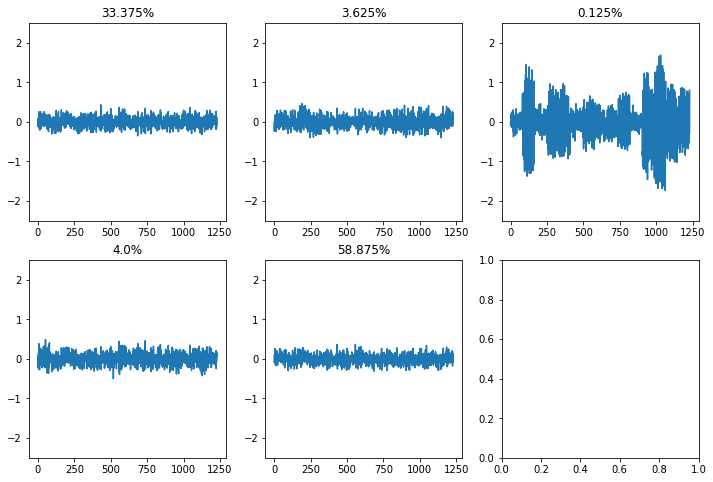

In [78]:
plot_centers(centers_train_c, labels_train_c, labels_ls, 1, -2.5, 2.5, 0.1)

In [15]:
np.savetxt(out_dir+'centers_Maca_cut.txt', centers_train_c)
np.savetxt(out_dir+'labels_Maca_cut.txt', labels_train_c)

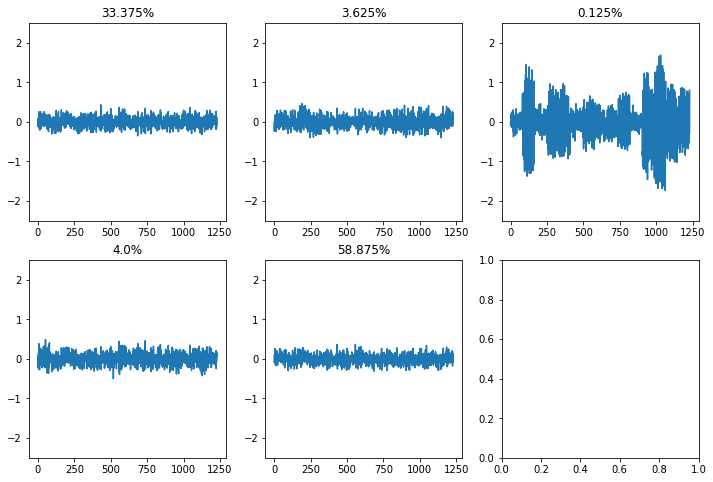

In [73]:
plot_centers(centers_train_c, labels_train_c, labels_ls, 1, -2.5, 2.5, 0.1)

In [56]:
test_E=[]
test_I=[]
for i in range(1):
    for j in range(2):
        
        sub ='Maca_'+str(i)+'_'+str(j)
        print(sub)
    
        train_E_sub, train_I_sub, test_E_sub, test_I_sub = get_EI(sub, out_dir, 0*50)
        test_E.append(test_E_sub -test_E_sub.mean(0))
        test_I.append(test_I_sub -test_I_sub.mean(0))
test_E = np.concatenate(test_E, axis=0)
test_I = np.concatenate(test_I, axis=0)

Maca_0_0
Maca_0_1


In [57]:
analytic_signal_test = test_E +(test_I)*1j#scipy.signal.hilbert(ts,axis=0)
Leads_test = get_leads_ts(analytic_signal_test, 1)

X_test = np.array(Leads_test)
labels_test, centers_test = leads_train(X_test, 5)

In [47]:
np.savetxt(out_dir+'centers_Maca_cut.txt', centers_train_c)

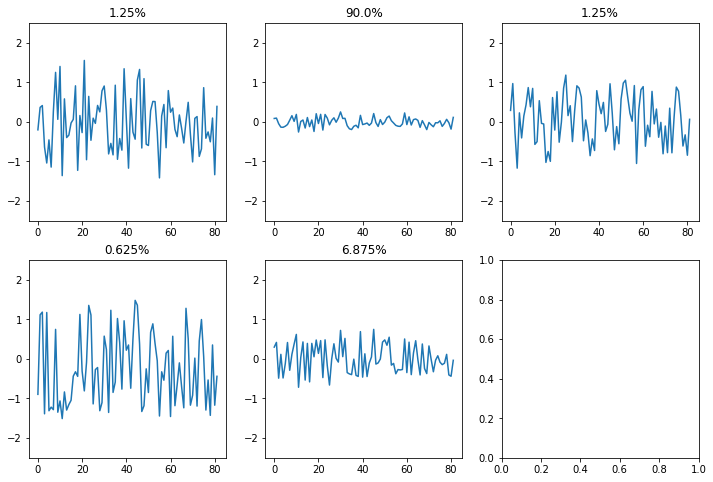

In [58]:
plot_centers(centers_test, labels_test, labels_ls, 1, -2.5, 2.5, 0.1)

In [86]:
lst = [ 1, 3, 4, 5, 2, 1, 4, 2, 1, 3, 5]


In [81]:
isinstance(lst, 'list')

TypeError: isinstance() arg 2 must be a type or tuple of types

In [84]:
isinstance(lst,list)

True

In [87]:
lst.index(1, f)

0